ref_power_fft (|FFT(Ez)|^2 합): 30016.166265021315
ref_flux (Poynting flux):       4.174804041474695


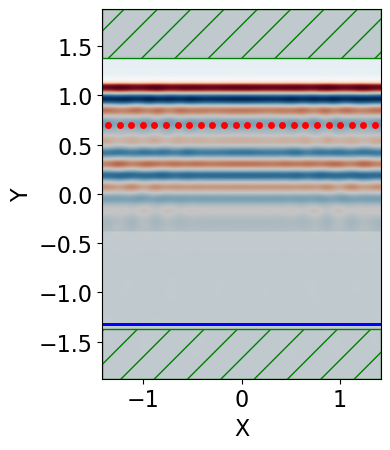

In [46]:
import math, os
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
import meep as mp
import meep.adjoint as mpa
from meep.materials import Ag
import matplotlib.pyplot as plt

mp.verbosity(0)
resolution = 50      # px/µm

lambda0 = 0.5            # [um]
fcen    = 1.0 / lambda0  # [1/um]
width = 1
fwidth = fcen*width

nfreq   = 1
frequencies = [fcen]

dpml = 0.5
dair = 1.0
hrod = 0.5     

dsub = 1.0
dAg  = 0.25

sx = 2.121                          # +-3차가 +-45도 나옴
sx = 2.828                          # +-4차가 +-45도 나옴
sy = dpml + dair + hrod + dsub + dAg + dpml
cell_size = mp.Vector3(sx, sy)

wrod = sx

substrate = mp.Medium(index=2.0)
air       = mp.Medium(index=1.0)

Medium1 = mp.Medium(index = 2.0)
Medium2 = mp.Medium(index = 1.0)

pml_layers = [
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.High),
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.Low)
]

DESIGN_W  = wrod
DESIGN_H  = hrod
design_c  = mp.Vector3(0, 0.5*sy - dpml - dAg - dsub - 0.5*hrod)
design_sz = mp.Vector3(DESIGN_W, DESIGN_H)

design_res = resolution
NX = int(DESIGN_W * design_res) + 1


DESIGN_MODE = 'free'  # or 'free' or 'grating'

if DESIGN_MODE == 'free':
    DESIRED_LAYERS = 1
    NY = int(round(DESIGN_H * design_res)) + 1
else:
    # 해상도와 레이어-패딩 조건을 동시에 만족
    DESIRED_LAYERS = 2       # 원하는 레이어 수 (패딩 1픽셀씩 자동)
    NY_min_layers = 2 * DESIRED_LAYERS - 1        # 레이어 L개 + 패딩 L-1개
    NY_res       = int(round(DESIGN_H * design_res))
    NY = max(NY_res, NY_min_layers)

n_vars = NX * NY

# 최소 피쳐/이진화 설정
MIN_FEATURE = 0.09    # ~80 nm
eta_i = 0.55
beta  = 8
beta_scale = 2
num_beta_steps = 3
filter_radius = mpa.get_conic_radius_from_eta_e(MIN_FEATURE, eta_i)

# x = np.ones((n_vars,), dtype=float) * 0.5
np.random.seed(42)

x = np.random.rand(n_vars) * 0.2 + 0.4

design_vars = mp.MaterialGrid(
    mp.Vector3(NX, NY, 0),
    Medium1, Medium2,
    grid_type="U_MEAN",
)
design_region = mpa.DesignRegion(design_vars, volume=mp.Volume(center=design_c, size=design_sz))

# ----------------------------
# geometry (디자인 포함)
# ----------------------------
geometry = [
    mp.Block(
        material=Ag,
        center=mp.Vector3(0, 0.5*sy - dpml - 0.5*dAg),
        size=mp.Vector3(mp.inf, dAg, mp.inf),
    ),
    # Substrate bulk (Ag 아래에 위치)
    mp.Block(
        material=substrate,
        center=mp.Vector3(0, 0.5*sy - dpml - dAg - 0.5*dsub),
        size=mp.Vector3(mp.inf, dsub, mp.inf),
    ),
    # Design block (텍스처 영역)
    mp.Block(
        material=design_vars,
        center=design_region.center,
        size=design_region.size,
    ),
]

src_center_pos = float(0.5*sy - dpml - dAg - dsub - 0.5*hrod+1.5)
src_size   = mp.Vector3(0, 0, 0)

num_sources = 24

src_time_object = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
src_component = mp.Ez
# 소스들의 y, z 좌표 기준값 설정
# src_base_center = mp.Vector3(0,src_center_pos,0)
src_base_center = mp.Vector3(0,0.7,0)
src_base_size = mp.Vector3(0, 0, 0)

# --- for loop를 사용하여 소스 리스트 직접 생성 ---
sources = []
if num_sources == 1:
    # 소스가 하나일 경우, 중앙(x=0)에 배치
    center = mp.Vector3(0, src_base_center.y, src_base_center.z)
    sources.append(
        mp.Source(
            src=src_time_object,
            component=src_component,
            center=center,
            size=src_base_size
        )
    )
elif num_sources > 1:
    # 소스 간의 간격(주기) 계산
    period = sx / num_sources
    # 첫 번째 소스의 위치 계산 (전체 배열이 중앙에 오도록)
    start_x = -sx / 2 + period / 2
    
    for i in range(num_sources):
        # 현재 소스의 x 좌표 계산
        x_pos = start_x + i * period
        center = mp.Vector3(x_pos, src_base_center.y, src_base_center.z)
        
        # 계산된 위치에 새로운 소스 객체를 생성하여 리스트에 추가
        sources.append(
            mp.Source(
                src=src_time_object,
                component=src_component,
                center=center,
                size=src_base_size
            )
        )

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    k_point = mp.Vector3(0,0,0),
    extra_materials=[Ag]
)

bottom_pml_top_y = -0.5 * sy + dpml
tmon_center = mp.Vector3(0, bottom_pml_top_y + (3 / resolution))
tmon_size   = mp.Vector3(sx, 0, 0)  
ref_dft = sim.add_dft_fields([mp.Ez], fcen, 0, 1, center=tmon_center, size=tmon_size)
ref_flux = sim.add_flux(fcen,          # 중심 주파수
                        0,             # 대역폭 df=0 → 단일 주파수
                        1,             # 샘플 수 1개
                        mp.FluxRegion(center=tmon_center,
                                      size=tmon_size))  # 라인 법선이 +y
sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-3))
# sim.run(until = 1)
sim.plot2D(fields = mp.Ez)

ref_Ez_line = np.squeeze(np.array(sim.get_dft_array(ref_dft, mp.Ez, 0))).ravel()
ref_fft_Ez  = np.fft.fftshift(np.fft.fft(ref_Ez_line))
ref_power_fft = np.sum(np.abs(ref_fft_Ez)**2)

# Flux 값(진짜 파워, Poynting 통합)
ref_flux_val = mp.get_fluxes(ref_flux)[0]   # 단일 주파수이므로 [0]

print("ref_power_fft (|FFT(Ez)|^2 합):", ref_power_fft)
print("ref_flux (Poynting flux):      ", -ref_flux_val)

<Axes: xlabel='X', ylabel='Y'>

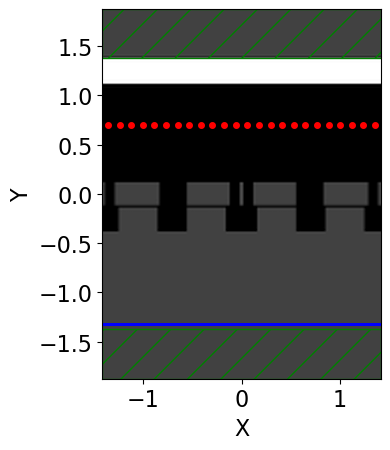

In [870]:
import math, os
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
import meep as mp
import meep.adjoint as mpa
from meep.materials import Ag
import matplotlib.pyplot as plt

mp.verbosity(0)
resolution = 50      # px/µm

lambda0 = 0.5            # [um]
fcen    = 1.0 / lambda0  # [1/um]
width = 1
fwidth = fcen*width

nfreq   = 1
frequencies = [fcen]

dpml = 0.5
dair = 1.0
hrod = 0.5     

dsub = 1.0
dAg  = 0.25

sx = 2.121                          # +-3차가 +-45도 나옴
sx = 2.828                          # +-4차가 +-45도 나옴
sy = dpml + dair + hrod + dsub + dAg + dpml
cell_size = mp.Vector3(sx, sy)

wrod = sx

substrate = mp.Medium(index=2.0)
air       = mp.Medium(index=1.0)

Medium1 = mp.Medium(index = 2.0)
Medium2 = mp.Medium(index = 1.0)

pml_layers = [
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.High),
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.Low)
]

DESIGN_W  = wrod
DESIGN_H  = hrod
design_c  = mp.Vector3(0, 0.5*sy - dpml - dAg - dsub - 0.5*hrod)
design_sz = mp.Vector3(DESIGN_W, DESIGN_H)

design_res = resolution
NX = int(DESIGN_W * design_res) + 1


DESIGN_MODE = 'grating'  # or 'free' or 'grating'

if DESIGN_MODE == 'free':
    DESIRED_LAYERS = 1
    NY = int(round(DESIGN_H * design_res)) + 1
else:
    # 해상도와 레이어-패딩 조건을 동시에 만족
    DESIRED_LAYERS = 2       # 원하는 레이어 수 (패딩 1픽셀씩 자동)
    NY_min_layers = 2 * DESIRED_LAYERS - 1        # 레이어 L개 + 패딩 L-1개
    NY_res       = int(round(DESIGN_H * design_res))
    NY = max(NY_res, NY_min_layers)

n_vars = NX * NY

# 최소 피쳐/이진화 설정
MIN_FEATURE = 0.09    # ~80 nm
eta_i = 0.55
beta  = 8
beta_scale = 2
num_beta_steps = 3
filter_radius = mpa.get_conic_radius_from_eta_e(MIN_FEATURE, eta_i)

# x = np.ones((n_vars,), dtype=float) * 0.5
# np.random.seed(42)

# x = np.random.rand(n_vars) * 0.2 + 0.4

design_vars = mp.MaterialGrid(
    mp.Vector3(NX, NY, 0),
    Medium1, Medium2,
    grid_type="U_MEAN",
)
design_region = mpa.DesignRegion(design_vars, volume=mp.Volume(center=design_c, size=design_sz))

# ----------------------------
# geometry (디자인 포함)
# ----------------------------
geometry = [
    mp.Block(
        material=Ag,
        center=mp.Vector3(0, 0.5*sy - dpml - 0.5*dAg),
        size=mp.Vector3(mp.inf, dAg, mp.inf),
    ),
    # Substrate bulk (Ag 아래에 위치)
    mp.Block(
        material=substrate,
        center=mp.Vector3(0, 0.5*sy - dpml - dAg - 0.5*dsub),
        size=mp.Vector3(mp.inf, dsub, mp.inf),
    ),
    # Design block (텍스처 영역)
    mp.Block(
        material=design_vars,
        center=design_region.center,
        size=design_region.size,
    ),
]

src_center_pos = float(0.5*sy - dpml - dAg - dsub - 0.5*hrod+1.5)
src_size   = mp.Vector3(0, 0, 0)

num_sources = 24

src_time_object = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
src_component = mp.Ez
# 소스들의 y, z 좌표 기준값 설정
# src_base_center = mp.Vector3(0,src_center_pos,0)
src_base_center = mp.Vector3(0,0.7,0)
src_base_size = mp.Vector3(0, 0, 0)

# --- for loop를 사용하여 소스 리스트 직접 생성 ---
sources = []
if num_sources == 1:
    # 소스가 하나일 경우, 중앙(x=0)에 배치
    center = mp.Vector3(0, src_base_center.y, src_base_center.z)
    sources.append(
        mp.Source(
            src=src_time_object,
            component=src_component,
            center=center,
            size=src_base_size
        )
    )
elif num_sources > 1:
    # 소스 간의 간격(주기) 계산
    period = sx / num_sources
    # 첫 번째 소스의 위치 계산 (전체 배열이 중앙에 오도록)
    start_x = -sx / 2 + period / 2
    
    for i in range(num_sources):
        # 현재 소스의 x 좌표 계산
        x_pos = start_x + i * period
        center = mp.Vector3(x_pos, src_base_center.y, src_base_center.z)
        
        # 계산된 위치에 새로운 소스 객체를 생성하여 리스트에 추가
        sources.append(
            mp.Source(
                src=src_time_object,
                component=src_component,
                center=center,
                size=src_base_size
            )
        )

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    k_point = mp.Vector3(0,0,0),
    extra_materials=[Ag]
)

bottom_pml_top_y = -0.5 * sy + dpml
tmon_center = mp.Vector3(0, bottom_pml_top_y + (3 / resolution))
tmon_size   = mp.Vector3(sx, 0, 0)                # x방향 한 주기 = sx

k = np.loadtxt("/home/min/EIDL/Tool/Meep/LGD/LGD Project/Mode decomposition/Kyungmin/Personal Project/Reciprocity_045/grating_2__1.txt")
design_vars.update_weights(k)

dft_t = sim.add_dft_fields([mp.Ez], fcen, 0, 1, center=tmon_center, size=tmon_size)
flux = sim.add_flux(fcen,          # 중심 주파수
                        0,             # 대역폭 df=0 → 단일 주파수
                        1,             # 샘플 수 1개
                        mp.FluxRegion(center=tmon_center,
                                      size=tmon_size))  # 라인 법선이 +y
sim.plot2D()

<Axes: xlabel='X', ylabel='Y'>

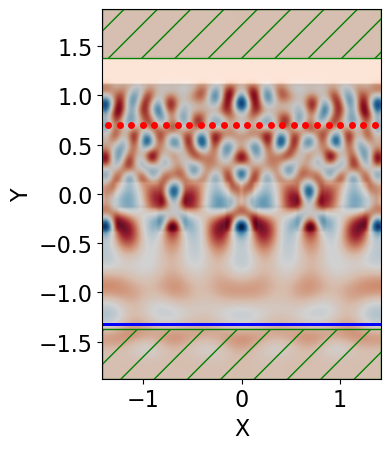

In [871]:
sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-5))
# sim.run(until = 1)
sim.plot2D(fields = mp.Ez)

In [872]:
# ===== 유틸: kx 인덱스/값 라벨 + 퍼센트 표시 =====
def annotate_kx_points(ax, kx_vec, y_vec, kx_marks, labels=None,
                       as_index=True,              # True: 인덱스, False: kx 값
                       dy_pts=(-10, -10),
                       show_marker=True,
                       show_percent=False,         # (추가) 퍼센트 표시 여부
                       fft_complex=None,           # (추가) 원본 복소 FFT (있으면 여기서 % 계산)
                       percent_ref=None):          # (추가) 분모(총 전력) override 가능
    """
    - show_percent=True 이고 fft_complex가 주어지면: 각 지점 % = |FFT|^2 / sum(|FFT|^2) * 100
    - show_percent=True 이고 fft_complex가 None이면: y_vec 자체가 이미 [%] 라고 가정
    """
    kx_marks = np.atleast_1d(kx_marks)
    if labels is None:
        labels = [f"kx[{m}]" if as_index else f"kx={m:.3f}" for m in kx_marks]

    # 표시할 인덱스 선택
    idx_list = []
    if as_index:
        for m in kx_marks:
            i = int(np.clip(int(m), 0, len(kx_vec)-1))
            idx_list.append(i)
    else:
        for kv in kx_marks:
            i = int(np.argmin(np.abs(kx_vec - kv)))
            idx_list.append(i)

    # 퍼센트 계산 준비
    if show_percent and (fft_complex is not None):
        # |FFT|^2 기준 총전력
        total_power = np.sum(np.abs(fft_complex)**2) if percent_ref is None else float(percent_ref)

    # 표시 루프
    for i, lab in zip(idx_list, labels):
        x_pt = kx_vec[i]; y_pt = y_vec[i]
        if show_marker:
            ax.scatter([x_pt], [y_pt], s=80, marker='o')

        # 퍼센트 문자열
        if show_percent:
            if fft_complex is not None:
                p_i = np.abs(fft_complex[i])**2
                pct = 100.0 * p_i / (total_power + 1e-30)
            else:
                pct = float(y_pt)  # y_vec이 이미 [%]라고 가정
            lab_full = f"{lab} ({pct:.2f}%)"
        else:
            lab_full = lab

        ax.annotate(lab_full,
                    xy=(x_pt, y_pt),
                    xytext=dy_pts, textcoords="offset points",
                    ha='right', va='top', fontsize=16)

    return idx_list  # 사용된 인덱스 반환

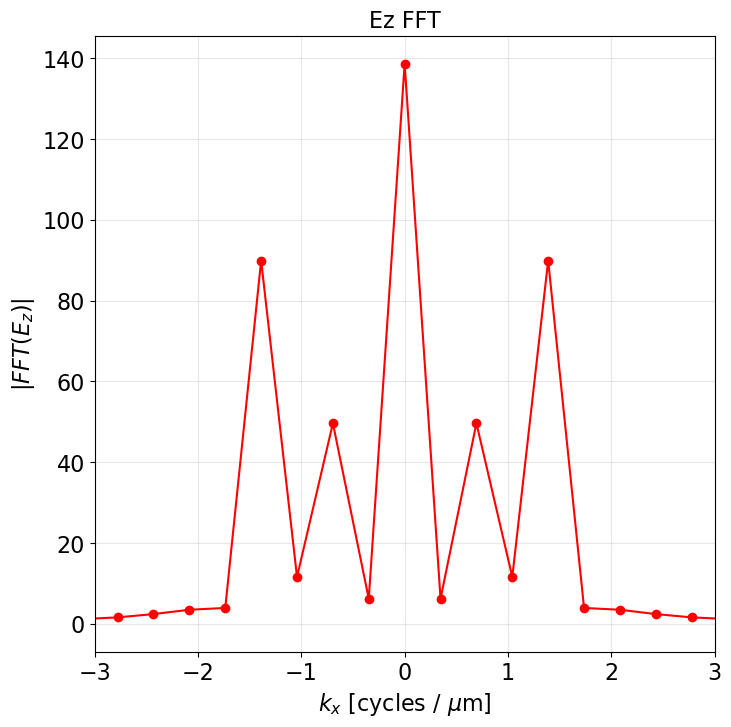

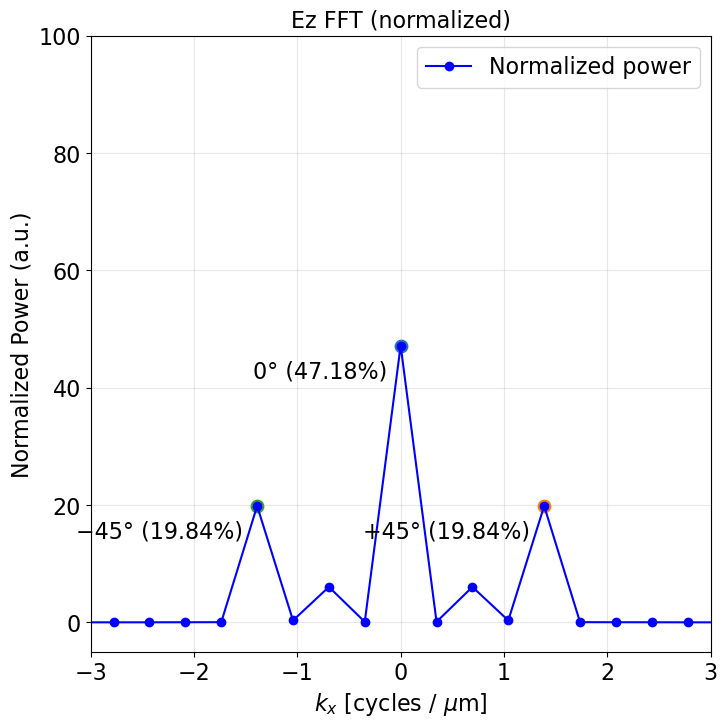

In [873]:
import matplotlib as mpl
mpl.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16
})

Ez_line = np.squeeze(np.array(sim.get_dft_array(dft_t, mp.Ez, 0))).ravel()  # 기존 Ez_line 유지, 1D 보장
fft_Ez  = np.fft.fftshift(np.fft.fft(Ez_line))  # 기존 변수명 유지
kx = np.fft.fftshift(np.fft.fftfreq(len(fft_Ez), d = 1/resolution))

# 찍을 인덱스들 (0, +4, -4 bin)
kx_indices_to_mark = [np.argmin(np.abs(kx)), np.argmin(np.abs(kx))+4, np.argmin(np.abs(kx))-4]
labels_idx = ["0 bin", "+45° bin(+4)", "−45° bin(−4)"]

plt.figure(figsize=(8,8))
plt.plot(kx, np.abs(fft_Ez),'ro-')
ax1 = plt.gca()

plt.xlabel(r"$k_x$ [cycles / $\mu$m]")
plt.ylabel(r"$|FFT(E_z)|$")
plt.title("Ez FFT")
plt.grid(True, which="both", alpha=0.3)
plt.xlim(-3,3)
plt.show()

# kx 값으로 직접 지정해도 됨 (as_index=False)
kx_values_to_mark = [0.0, +1.414, -1.414]
labels_val = ["0°", "+45°", "−45°"]

############ 정규화 버전 ############
total_power = np.sum(np.abs(fft_Ez)**2)
normal_fft_Ez = (np.abs(fft_Ez)**2) / (total_power) * 100  # [%]

plt.figure(figsize=(8,8))
plt.plot(kx, normal_fft_Ez, 'bo-', label="Normalized power")
ax2 = plt.gca()

_ = annotate_kx_points(ax2, kx, normal_fft_Ez, kx_values_to_mark,
                       labels=labels_val,
                       as_index=False,          # ← kx 값으로 매칭
                       dy_pts=(-10,-10),
                       show_marker=True,
                       show_percent=True,       # ← 퍼센트 표시 ON
                       fft_complex=None)        # ← y가 이미 [%]이므로 생략

plt.xlabel(r"$k_x$ [cycles / $\mu$m]")
plt.ylabel(r"Normalized Power (a.u.)")
plt.title("Ez FFT (normalized)")
plt.xlim(-3, 3)
plt.ylim(-5, 100)
plt.grid(True, which="both", alpha=0.3)
plt.legend(loc="best")
plt.show()


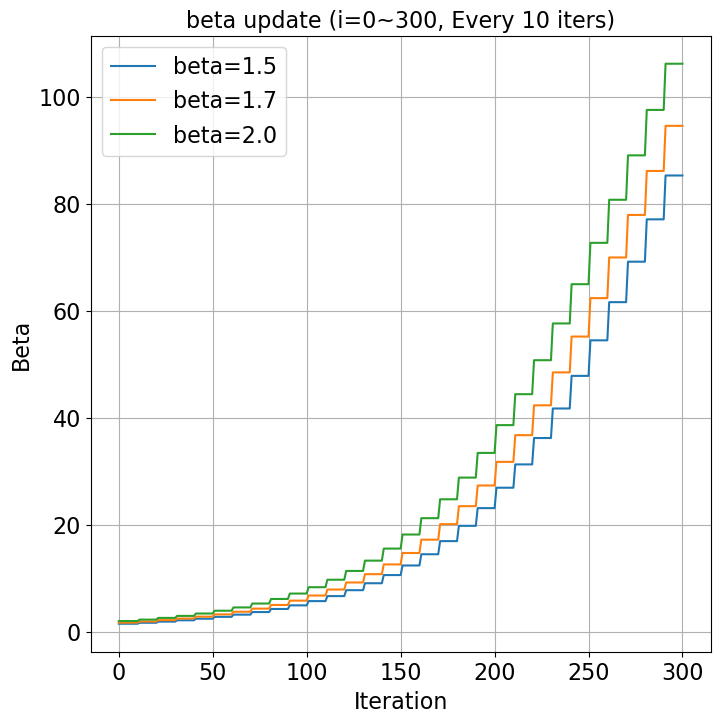

In [591]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def simulate_beta(beta0: float, iters: int = 300, step: int = 10):
    # 기록용
    beta_hist = []
    idx_hist = []
    
    # 업데이트용 변수명은 'beta' 그대로 유지
    beta = float(beta0)  # beta0: 초기값(추가 변수, 혼동 방지용 주석)
    
    for i in range(iters + 1):
        # 기록: 모든 i에서 기록(업데이트가 없는 구간은 직선 유지)
        beta_hist.append(beta)
        idx_hist.append(i)
        
        # 매 10번마다 업데이트 (i>0 이면서 i%step==0일 때)
        if i > 0 and (i % step == 0):
            beta = beta + 9*np.tanh((beta - 0.5) * 0.02)
    
    return np.array(idx_hist), np.array(beta_hist)

# 여러 초기값 예시 (그래프 한 장에 비교)
beta0_list = [1.5, 1.7, 2.0]  # 필요 시 이 리스트만 수정하세요.
results = []

plt.figure(figsize=(8, 8))
for beta0 in beta0_list:
    idx_hist, beta_hist = simulate_beta(beta0=beta0, iters=300, step=10)
    results.append((beta0, idx_hist, beta_hist))
    plt.plot(idx_hist, beta_hist, label=f"beta={beta0}")

plt.title("beta update (i=0~300, Every 10 iters)")
plt.xlabel("Iteration")
plt.ylabel("Beta")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import math, os
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
import meep as mp
import meep.adjoint as mpa
from meep.materials import Ag
import matplotlib.pyplot as plt

mp.verbosity(0)
resolution = 50      # px/µm

lambda0 = 0.5            # [um]
fcen    = 1.0 / lambda0  # [1/um]
width = 1
fwidth = fcen*width

nfreq   = 1
frequencies = [fcen]

dpml = 0.5
dair = 1.0
hrod = 0.5     

dsub = 1.0
dAg  = 0.25

sx = 2.121                          # +-3차가 +-45도 나옴
sx = 2.828                          # +-4차가 +-45도 나옴
sy = dpml + dair + hrod + dsub + dAg + dpml
cell_size = mp.Vector3(sx, sy)

wrod = sx

substrate = mp.Medium(index=2.0)
air       = mp.Medium(index=1.0)

Medium1 = mp.Medium(index = 2.0)
Medium2 = mp.Medium(index = 1.0)

pml_layers = [
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.High),
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.Low)
]

DESIGN_W  = wrod
DESIGN_H  = hrod
design_c  = mp.Vector3(0, 0.5*sy - dpml - dAg - dsub - 0.5*hrod)
design_sz = mp.Vector3(DESIGN_W, DESIGN_H)


design_res = resolution
NX = int(DESIGN_W * design_res) + 1

DESIGN_MODE = 'grating'  # or 'free' or 'grating'

if DESIGN_MODE == 'free':
    NY = int(round(DESIGN_H * design_res)) + 1
else:
    # 해상도와 레이어-패딩 조건을 동시에 만족
    DESIRED_LAYERS = 2       # 원하는 레이어 수 (패딩 1픽셀씩 자동)
    NY_min_layers = 2 * DESIRED_LAYERS - 1        # 레이어 L개 + 패딩 L-1개
    NY_res       = int(round(DESIGN_H * design_res))
    NY = max(NY_res, NY_min_layers)

n_vars = NX * NY

# 최소 피쳐/이진화 설정
MIN_FEATURE = 0.09    # ~80 nm
eta_i = 0.55
beta  = 2
beta_scale = 2
num_beta_steps = 3
filter_radius = mpa.get_conic_radius_from_eta_e(MIN_FEATURE, eta_i)

# x = np.ones((n_vars,), dtype=float) * 0.5
np.random.seed(42)

x = np.random.rand(n_vars) * 0.2 + 0.4
# x = np.ones(n_vars)*0.5

design_vars = mp.MaterialGrid(
    mp.Vector3(NX, NY, 0),
    Medium1, Medium2,
    grid_type="U_MEAN",
)
design_region = mpa.DesignRegion(design_vars, volume=mp.Volume(center=design_c, size=design_sz))
design_vars.update_weights(x.reshape(NX, NY))

# ----------------------------
# geometry (디자인 포함)
# ----------------------------
geometry = [
    mp.Block(
        material=Ag,
        center=mp.Vector3(0, 0.5*sy - dpml - 0.5*dAg),
        size=mp.Vector3(mp.inf, dAg, mp.inf),
    ),
    # Substrate bulk (Ag 아래에 위치)
    mp.Block(
        material=substrate,
        center=mp.Vector3(0, 0.5*sy - dpml - dAg - 0.5*dsub),
        size=mp.Vector3(mp.inf, dsub, mp.inf),
    ),
    # Design block (텍스처 영역)
    mp.Block(
        material=design_vars,
        center=design_region.center,
        size=design_region.size,
    ),
]

bottom_pml_top_y = -0.5 * sy + dpml
src_center = mp.Vector3(0, bottom_pml_top_y + (3 / resolution))
src_size   = mp.Vector3(sx, 0, 0)

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        component=mp.Ez,  # TM 편광의 경우
        center=mp.Vector3(0, src_center.y),
        size=mp.Vector3(sx, 0)
    )
]

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    k_point = mp.Vector3(0,0,0),
    extra_materials=[Ag],
    default_material=mp.Medium(index=1),
)

# --- FourierFields 모니터 (y=0.7 선) ---
ff_center = mp.Vector3(0, 0.7, 0)
ff_size   = mp.Vector3(sx, 0, 0)
ff_vol    = mp.Volume(center=ff_center, size=ff_size)

ff_Ez = mpa.FourierFields(sim, volume=ff_vol, component=mp.Ez)
# -----------------------------------------
# 1) DFT 모니터 설치 (ff_Ez와 동일한 위치/길이)
# -----------------------------------------
dft_line = sim.add_dft_fields([mp.Ez], fcen, 0, 1, center=ff_center, size=ff_size)

margin = 0.4  # [um] 디자인 하단 바로 아래로 살짝 내림

# --- FourierFields 모니터 (y=0.7 선) ---
ff_center = mp.Vector3(0, 0.7, 0)
ff_size   = mp.Vector3(sx, 0, 0)
ff_vol    = mp.Volume(center=ff_center, size=ff_size)

ff_Ez = mpa.FourierFields(sim, volume=ff_vol, component=mp.Ez)

# --- k_x vector 추가 보정 ---
margin = 0.4  # [um] 디자인 하단 바로 아래로 살짝 내림

# 디자인 하단 y좌표
design_bottom_y = design_region.center.y - 0.5 * design_region.size.y

# 추가 모니터의 중심과 크기 (x는 주기 전체 길이)
ff_center_below = mp.Vector3(0, design_bottom_y - margin, 0)
ff_size_below   = mp.Vector3(sx, 0, 0)
ff_vol_below    = mp.Volume(center=ff_center_below, size=ff_size_below)

ff_check_Ez = mpa.FourierFields(sim, volume=ff_vol_below, component=mp.Ez)

def J_kx(Ez_top, Ez_bot):
    # 타깃 분포
    T0, Tp = 0.6, 0.2
    q_star = npa.array([Tp, T0, Tp])
    w_d, w_s = 0.7, 0.3
    eps = 1e-12

    def P0_P45(Ez):
        Ez = npa.ravel(Ez)
        F  = npa.fft.fftshift(npa.fft.fft(Ez))
        kx = npa.fft.fftshift(npa.fft.fftfreq(len(F), d=1.0/resolution))
        k0  = npa.argmin(npa.abs(kx))                                 # 0°
        k45 = npa.argmin(npa.abs(kx - (1.0/lambda0)*npa.sin(npa.pi/4)))  # +45°
        P   = npa.abs(F)**2
        P   = P / (npa.sum(P) + eps)                                   # 전력 정규화
        return P[k0], P[k45]

    def js_divergence(p, q):
        m = 0.5*(p + q)
        # KL(p‖m) + KL(q‖m): 0*log(0/.) = 0 취급을 위해 eps 더함
        kl_pm = npa.sum(p * (npa.log((p + eps)/(m + eps))))
        kl_qm = npa.sum(q * (npa.log((q + eps)/(m + eps))))
        return 0.5*(kl_pm + kl_qm)  # ∈ [0, ln 2]

    def line_loss(Ez):
        P0, P45 = P0_P45(Ez)
        S  = P0 + 2.0*P45                           # 선택 성분 총합 (절대 세기)
        qh = npa.array([P45, P0, P45]) / (S + eps)   # 관측 분포 [−45, 0, +45] (대칭 가정)
        L_dist = js_divergence(qh, q_star) / npa.log(2.0)   # ∈ [0,1]
        L_sum  = ((S - 1.0) / 2.0)**2                        # ∈ [0,1]
        return w_d*L_dist + w_s*L_sum

    # 두 라인 평균 손실 (0~1)
    L = 0.5*(line_loss(Ez_top) + line_loss(Ez_bot))
    return 1/(1+L)

def J_kx(Ez_top, Ez_bot):
    T0, T45 = 0.6, 0.2
    beta = 10.0
    eps = 1e-12
    
    # [수정] Softplus의 최솟값(ln 2) 정의
    min_softplus = npa.log(2.0)

    def get_power_components(Ez):
        # (이전과 동일)
        Ez = npa.ravel(Ez)
        F = npa.fft.fftshift(npa.fft.fft(Ez))
        P = npa.abs(F)**2
        kx = npa.fft.fftshift(npa.fft.fftfreq(len(F), d=1.0/resolution))
        idx_0 = npa.argmin(npa.abs(kx))
        idx_45 = npa.argmin(npa.abs(kx - (1.0/lambda0)*npa.sin(npa.pi/4)))
        return P[idx_0], P[idx_45]

    def line_loss(Ez):
        P0, P45 = get_power_components(Ez)
        S = P0 + 2.0 * P45 + eps
        q0 = P0 / S
        q45 = P45 / S
        
        # [수정] 오차가 0일 때 Loss가 0이 되도록 min_softplus를 뺌
        loss_0  = npa.log(1.0 + npa.exp(beta * npa.abs(q0 - T0))) - min_softplus
        loss_45 = npa.log(1.0 + npa.exp(beta * npa.abs(q45 - T45))) - min_softplus
        
        return loss_0 + 2.0 * loss_45

    L_avg = 0.5 * (line_loss(Ez_top) + line_loss(Ez_bot))
    
    # 이제 L_avg의 최솟값이 0이므로, J의 최댓값은 1이 됩니다.
    return 1.0 / (1.0 + L_avg)

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J_kx],
    objective_arguments=[ff_Ez, ff_check_Ez],
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-3,
    minimum_run_time=50/fcen
)

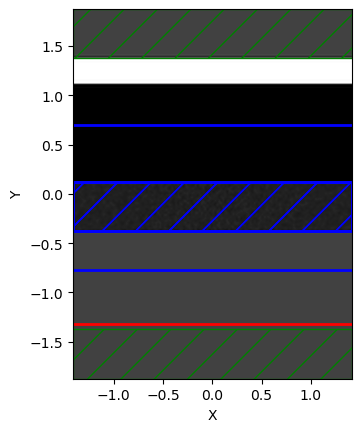

In [7]:
opt.plot2D(True)

In [8]:
eta = 0.5

from autograd.extend import primitive, defvjp

@primitive
def _layer_division_with_padding_2d(X, L):
    NX, NY = X.shape
    L = int(L)
    if NY <= 1:
        return X
    if L <= 1:
        m = npa.mean(X, axis=1, keepdims=True)     # (NX,1)
        return npa.tile(m, (1, NY))                # (NX,NY) 전체 y-평탄화
    L_eff = min(L, (NY + 1) // 2)
    pads = L_eff - 1
    avail = NY - pads
    base, extra = divmod(avail, L_eff)
    sizes = [base + (1 if i < extra else 0) for i in range(L_eff)]
    cols, y0 = [], 0
    for i, s in enumerate(sizes):
        m = npa.mean(X[:, y0:y0+s], axis=1, keepdims=True)  # (NX,1)
        cols.append(npa.tile(m, (1, s)))                    # (NX,s)
        y0 += s
        if i < L_eff - 1:
            cols.append(npa.full((NX, 1), 0.5))             # pad 1픽셀
    return npa.concatenate(cols, axis=1)

def _ldp_vjp(g, X, L):
    NX, NY = X.shape
    L = int(L)
    if NY <= 1:
        return g
    if L <= 1:
        gsum = npa.sum(g, axis=1, keepdims=True)           # (NX,1)
        return npa.tile(gsum / NY, (1, NY))                # (NX,NY)
    L_eff = min(L, (NY + 1) // 2)
    pads = L_eff - 1
    avail = NY - pads
    base, extra = divmod(avail, L_eff)
    sizes = [base + (1 if i < extra else 0) for i in range(L_eff)]
    gout = npa.zeros_like(X)
    y_in = 0
    y_out = 0
    for i, s in enumerate(sizes):
        g_seg = g[:, y_out:y_out + s]                      # (NX,s)
        gsum = npa.sum(g_seg, axis=1, keepdims=True)       # (NX,1)
        gout = npa.concatenate(
            (gout[:, :y_in], npa.tile(gsum / s, (1, s)), gout[:, y_in + s:]),
            axis=1
        )
        y_in  += s
        y_out += s
        if i < L_eff - 1:
            y_out += 1                                     # pad grad=0
    return gout

defvjp(
    _layer_division_with_padding_2d,
    lambda ans, X, L: lambda g: _ldp_vjp(g, X, L),
    lambda ans, X, L: lambda g: None
)

def grating_mapping(x, eta, beta, desired_layers=None):
    X = npa.clip(x.reshape(NX, NY), 0.0, 1.0)              # (NX,NY)
    L = DESIRED_LAYERS if desired_layers is None else int(desired_layers)
    X = _layer_division_with_padding_2d(X, L)
    X = mpa.tanh_projection(X, beta=float(beta), eta=float(eta))
    X = 0.5 * (npa.flipud(X) + X)
    X = mpa.tanh_projection(X, beta=float(beta), eta=float(eta))
    return npa.clip(X, 0.0, 1.0).reshape(NX * NY)

def free_mapping(x, eta, beta):
    filt = mpa.conic_filter(x, filter_radius, DESIGN_W, DESIGN_H, design_res)   # (NY, NX)
    filt = (
        npa.flipud(filt) + filt
    ) / 2
    projected_field = mpa.tanh_projection(filt, beta, eta)

    return projected_field.flatten()

mapping = free_mapping if DESIGN_MODE == 'free' else grating_mapping

evaluation_history = []
cur_iter = [0]

def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])  # compute objective and gradient
    dJdrho_flat = np.asarray(dJ_du).ravel()

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, dJdrho_flat
        )  # backprop

    evaluation_history.append(np.real(f0))

    cur_iter[0] = cur_iter[0] + 1
    print(f"FOM : {np.real(f0)}")
    return np.real(f0)

In [9]:
def compute_layer_layout(NX, NY, L):
    L_eff = min(int(L), (NY + 1)//2)
    L_eff = max(L_eff, 1)
    pads = L_eff - 1
    avail = NY - pads
    base, extra = divmod(avail, L_eff)
    sizes = [base + (1 if i < extra else 0) for i in range(L_eff)]
    slices = []
    y0 = 0
    for s in sizes:
        slices.append((y0, y0+s)); y0 += s
    pad_cols = list(range(avail, NY))
    return slices, pad_cols, (L_eff, pads, avail, sizes)

def build_bounds_for_grating_auto(NX, NY, desired_layers, active_bounds=(0.0,1.0),
                                  fix_unused_to_half=True, pad_value=0.5, eps_fix=1e-9):
    slices, pad_cols, meta = compute_layer_layout(NX, NY, desired_layers)
    lb = np.zeros(NX*NY, dtype=float)
    ub = np.ones (NX*NY, dtype=float)
    lo, hi = map(float, active_bounds)
    # 레이어 내부 공통 bounds
    for (y0, y1) in slices:
        for iy in range(y0, y1):
            idxs = np.arange(iy, NX*NY, NY, dtype=int)
            lb[idxs] = lo; ub[idxs] = hi
    # 입력의 "사용되지 않는" pad 열: 0.5±ε
    if fix_unused_to_half and pad_cols:
        lo_pad = pad_value - eps_fix; hi_pad = pad_value + eps_fix
        for iy in pad_cols:
            idxs = np.arange(iy, NX*NY, NY, dtype=int)
            lb[idxs] = lo_pad; ub[idxs] = hi_pad
    # 디버그
    L_eff, pads, avail, sizes = meta
    print(f"[LAYOUT] L={desired_layers} → L_eff={L_eff}, pads={pads}, avail={avail}, sizes={sizes}")
    print(f"[LAYOUT] unused input pad columns: {pad_cols}")
    return lb, ub

def validate_nlopt_setup(x, lb, ub, n_expected):
    x  = np.asarray(x,  dtype=float, order='C')
    lb = np.asarray(lb, dtype=float, order='C')
    ub = np.asarray(ub, dtype=float, order='C')
    assert x.ndim==1 and lb.ndim==1 and ub.ndim==1
    assert x.size==n_expected and lb.size==n_expected and ub.size==n_expected
    if np.any(~np.isfinite(x)) or np.any(~np.isfinite(lb)) or np.any(~np.isfinite(ub)):
        raise ValueError("x/lb/ub contain NaN/inf")
    if np.any(lb > ub):
        i = np.where(lb>ub)[0][0]
        raise ValueError(f"lb>ub at index {i}: lb={lb[i]}, ub={ub[i]}")
    # x를 bounds로 클립
    x = np.minimum(np.maximum(x, lb), ub)
    return x, lb, ub


In [10]:
import nlopt
algorithm = nlopt.LD_MMA

n = NX * NY

if DESIGN_MODE == 'grating':
    lb, ub = build_bounds_for_grating_auto(NX, NY, DESIRED_LAYERS,
                                           active_bounds=(0.0,1.0),
                                           fix_unused_to_half=True,
                                           pad_value=0.5, eps_fix=1e-9)
else:
    lb = np.zeros(n); ub = np.ones(n)

# 유효성 검증 + 초기값 클리핑
x, lb, ub = validate_nlopt_setup(x, lb, ub, n)

cur_beta = 2
beta_scale = 1.4
num_betas = 10
update_factor = 10

def binarization_ratio_from_x(x_vec, eta, beta, tol=0.05):
    u = mapping(x_vec, eta, beta)                 # (NX*NY,) 1D
    u = np.asarray(u, dtype=float).ravel()
    mask_binary = (u <= tol) | (u >= (1.0 - tol)) # near-0 or near-1
    ratio = float(np.mean(mask_binary))           # 0~1
    return ratio, u

binarization_ratio_hist = np.full(num_betas, np.nan, dtype=float)

for iters in range(num_betas):
    print("current beta:", cur_beta)

    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)

    x[:] = solver.optimize(x)

    bin_ratio, u_now = binarization_ratio_from_x(x, eta_i, cur_beta, tol=0.02)
    binarization_ratio_hist[iters] = bin_ratio
    print(f"[BIN] beta={cur_beta:.4g} → binarization={100.0*bin_ratio:.2f}%")

    if bin_ratio >= 0.98:
        print("[STOP] Binarization ≥ 95% 달성. beta를 ∞로 두고 최적화를 중단합니다.")
        cur_beta = float("inf")   # 논리적 설정(이후 사용 안 함)
        break

    cur_beta *= beta_scale


[LAYOUT] L=2 → L_eff=2, pads=1, avail=24, sizes=[12, 12]
[LAYOUT] unused input pad columns: [24]
current beta: 2
Current iteration: 1
Starting forward run...


Starting adjoint run...


Calculating gradient...
FOM : 0.1390721442569915
Current iteration: 2
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.13907300976806128
Current iteration: 3
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.1390823109989375
Current iteration: 4
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.1393659401902633
Current iteration: 5
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.36679471964045296
Current iteration: 6
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.16983846262566565
Current iteration: 7
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.18107157874278687
Current iteration: 8
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.13984303431558523
Current iteration: 9
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.15573017555206428
Current iteration: 10
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.1576491665407105
[BIN] beta=2 → binarization=0.00%
current beta: 2.8
Current iteration: 11
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.26126780554349516
Current iteration: 12
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.26630919759948163
Current iteration: 13
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.2643358949647389
Current iteration: 14
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.28518464384769276
Current iteration: 15
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.2690218824092
Current iteration: 16
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.29106159484155864
Current iteration: 17
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.2894063919971315
Current iteration: 18
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.2935593963384296
Current iteration: 19
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.27163521456996526
Current iteration: 20
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.2861086811747295
[BIN] beta=2.8 → binarization=0.00%
current beta: 3.9199999999999995
Current iteration: 21
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.26740877718482564
Current iteration: 22
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.26718340191884826
Current iteration: 23
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.2686156981325597
Current iteration: 24
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM : 0.2694306631054102
Current iteration: 25
Starting forward run...
Starting adjoint run...


KeyboardInterrupt: 

In [867]:
p = design_vars.weights
rho_mapped  = np.asarray(mapping(p, eta_i, cur_beta))        # shape: (NY*NX,)
weights_sym = rho_mapped.reshape(NX, NY)

np.savetxt(f'{DESIGN_MODE}_{DESIRED_LAYERS}__1.txt',weights_sym)

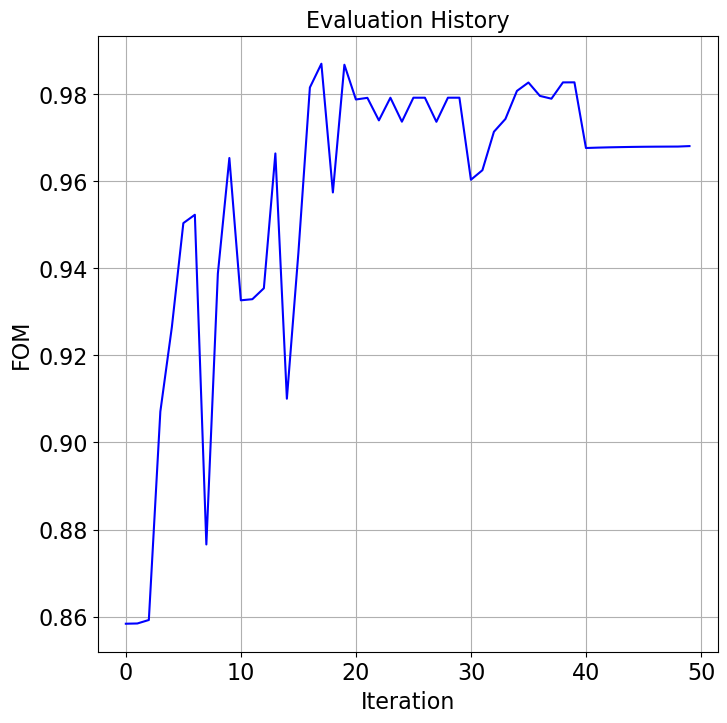

In [868]:
plt.figure(figsize = (8,8))
plt.title("Evaluation History")
plt.plot(np.array(evaluation_history), "b-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

In [699]:
import numpy as np

def evaluate_in_01(file_path="/mnt/data/xx.txt", tol=0.0):
    # 1) 데이터 로드 (공백 구분 2D/1D 모두 허용)
    arr = np.loadtxt(file_path, dtype=float)
    x = np.asarray(arr).ravel()  # 편의상 1D로 펼침

    # 2) 기본 통계
    amin, amax, amean = float(np.min(x)), float(np.max(x)), float(np.mean(x))

    # 3) 범위 내/밖 비율 계산
    in_mask  = (x >= (0.0 - tol)) & (x <= (1.0 + tol))
    below    = x < (0.0 - tol)
    above    = x > (1.0 + tol)

    n = x.size
    n_in = int(np.sum(in_mask))
    n_below = int(np.sum(below))
    n_above = int(np.sum(above))

    ratio_in   = 100.0 * n_in / n
    ratio_out  = 100.0 - ratio_in
    ratio_low  = 100.0 * n_below / n
    ratio_high = 100.0 * n_above / n

    # 4) (선택) 범위를 벗어난 정도의 평균/최대 초과량(얼마나 멀리 있는지)
    #    - [0,1] 구간 밖일 때만의 초과량 평균/최대
    deficit = np.maximum(0.0, (0.0 - tol) - x)     # 0보다 작은 만큼
    excess  = np.maximum(0.0, x - (1.0 + tol))     # 1보다 큰 만큼
    violation = deficit + excess
    mean_violation = float(np.mean(violation))
    max_violation  = float(np.max(violation))

    # 5) 요약 출력
    print(f"[INFO] file: {file_path}")
    print(f"[STAT] shape={arr.shape}  min={amin:.6g}  max={amax:.6g}  mean={amean:.6g}")
    print(f"[RANGE] tol={tol:g} -> in[0,1]={ratio_in:.3f}% | out={ratio_out:.3f}% "
          f"(below={ratio_low:.3f}%, above={ratio_high:.3f}%)")
    print(f"[DIST] mean violation={mean_violation:.6g} | max violation={max_violation:.6g}")

    return {
        "shape": arr.shape,
        "min": amin, "max": amax, "mean": amean,
        "tol": tol,
        "ratio_in_percent": ratio_in,
        "ratio_out_percent": ratio_out,
        "ratio_below_percent": ratio_low,
        "ratio_above_percent": ratio_high,
        "mean_violation": mean_violation,
        "max_violation": max_violation,
    }

res = evaluate_in_01("/home/min/EIDL/Tool/Meep/LGD/LGD Project/Mode decomposition/Kyungmin/Personal Project/Reciprocity_045/grating_1.txt", tol=0.0)       
# res = evaluate_in_01("/home/min/EIDL/Tool/Meep/LGD/LGD Project/Mode decomposition/Kyungmin/Personal Project/Reciprocity_045/xx.txt", tol=1e-6)      # 미세한 수치 잡음 허용


[INFO] file: /home/min/EIDL/Tool/Meep/LGD/LGD Project/Mode decomposition/Kyungmin/Personal Project/Reciprocity_045/grating_1.txt
[STAT] shape=(142, 25)  min=0  max=1  mean=0.507042
[RANGE] tol=0 -> in[0,1]=100.000% | out=0.000% (below=0.000%, above=0.000%)
[DIST] mean violation=0 | max violation=0


In [261]:
db = 1e-3
choose = 30
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db, filter = free_mapping)

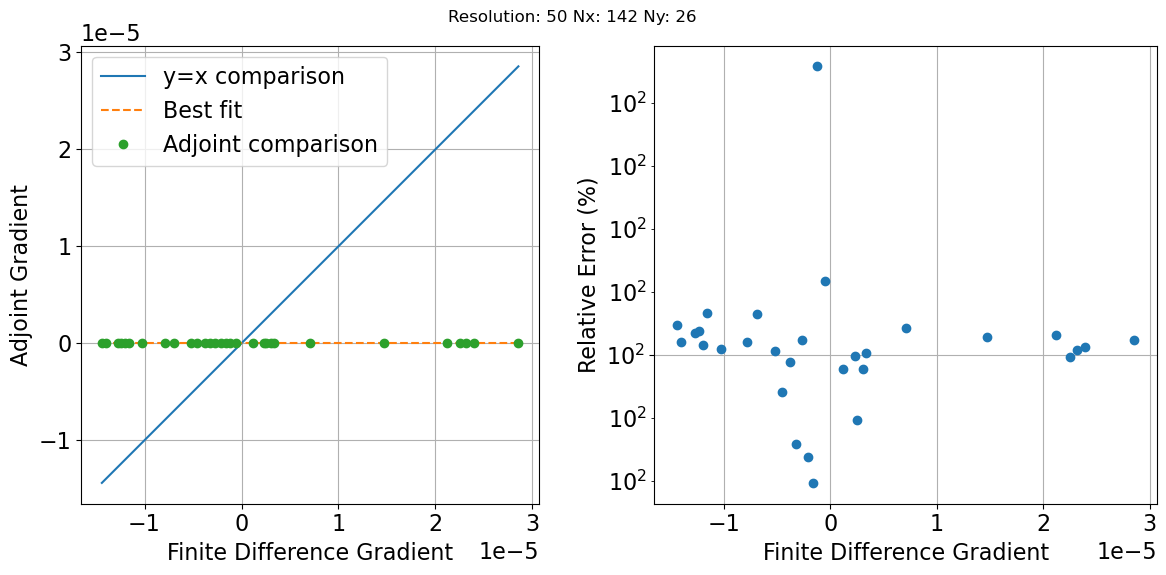

In [262]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du[idx], 1)

min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Nx: {} Ny: {}".format(resolution, NX, NY))
plt.show()

Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...


Starting forward run...
[INFO] f(x) = -9.583655e-01
[FIT] y = 10.452069 * x + 2.912905e-04
[FIT] R^2 = 0.981992
[ERR] mean = 1.157e+03% | median = 1.068e+03% | max = 3.362e+03%


/tmp/ipykernel_1751/1218841065.py:58: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(fd_vals, fit_line,'r-', linestyle="--", label="Best fit", )


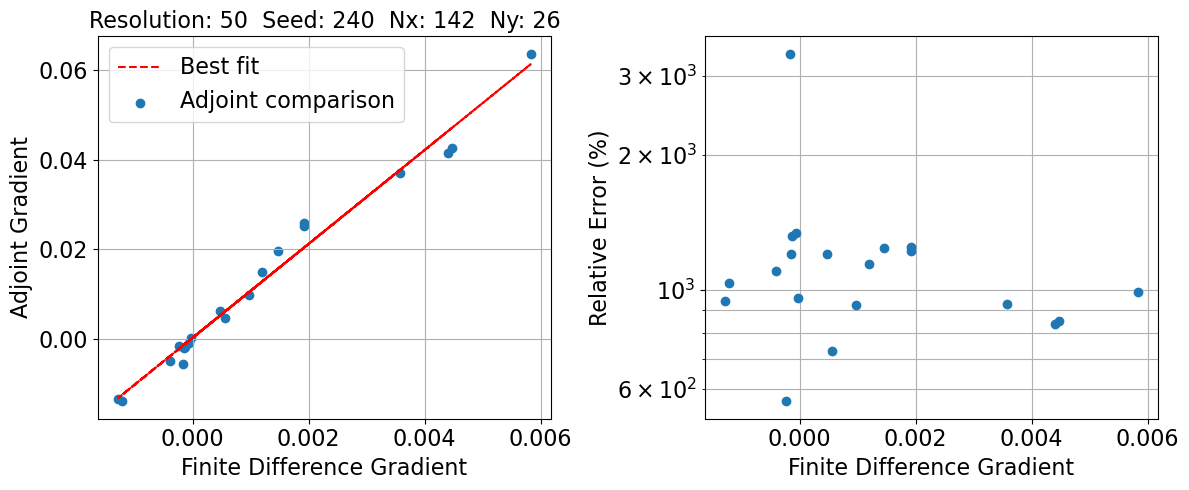

In [195]:
# ===== 설정: y=x 기준선 표시 여부 =====
SHOW_Y_EQUALS_X = False  # 필요 없으면 False로 하거나, 해당 라인을 주석 처리

def free_mapping(x, eta, beta):
    filt = mpa.conic_filter(x, filter_radius, DESIGN_W, DESIGN_H, design_res)   # (NY, NX)
    projected_field = mpa.tanh_projection(filt, beta, eta)
    projected_field = (
        npa.flipud(projected_field) + projected_field
    ) / 2

    return projected_field.flatten()
eta = 0.5
x = free_mapping(x, eta, beta)
# 1) 현재 설계변수에서 목적함수 값과 adjoint gradient 계산
f0, grad = opt([x], need_value=True, need_gradient=True)
f0 = float(npa.real(f0))
grad = np.asarray(grad).ravel()

# 2) FD 샘플 좌표 선택 및 중앙차분(FD) 계산
seed_fd = 240
rng = np.random.default_rng(seed_fd)
num_fd = min(20, x.size)
indices = rng.choice(x.size, size=num_fd, replace=False)

h = 1e-5
fd_vals = np.zeros(num_fd, dtype=float)
for k, i in enumerate(indices):
    x_plus  = x.copy()
    x_minus = x.copy()
    x_plus[i]  = np.clip(x_plus[i]  + h, 0.0, 1.0)
    x_minus[i] = np.clip(x_minus[i] - h, 0.0, 1.0)

    f_plus, _  = opt([x_plus],  need_value=True, need_gradient=False)
    f_minus, _ = opt([x_minus], need_value=True, need_gradient=False)
    fd_vals[k] = (float(npa.real(f_plus)) - float(npa.real(f_minus))) / (2.0 * h)

adj_vals = grad[indices]

# 3) 직선 적합(y = a x + b) 및 R^2
coef = np.polyfit(fd_vals, adj_vals, deg=1)  # x=FD, y=Adjoint
a, b = coef[0], coef[1]
fit_line = a * fd_vals + b
ss_res = np.sum((adj_vals - fit_line) ** 2.0)
ss_tot = np.sum((adj_vals - np.mean(adj_vals)) ** 2.0)
r2 = 1.0 - (ss_res / ss_tot if ss_tot > 0 else 0.0)

# 4) 상대오차(%): 기준을 FD로 설정
eps = 1e-12
rel_err_pct = 100.0 * np.abs(adj_vals - fd_vals) / (np.abs(fd_vals) + eps)

# 5) 플롯 (좌: Adjoint vs FD, 우: Relative Error)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# -- (좌) Adjoint vs FD
ax = axes[0]
if SHOW_Y_EQUALS_X:
    ax.plot(fd_vals, fd_vals, label="y=x comparison")  # 필요 없으면 이 줄만 주석 처리
ax.plot(fd_vals, fit_line,'r-', linestyle="--", label="Best fit", )
ax.scatter(fd_vals, adj_vals, label="Adjoint comparison")
ax.set_xlabel("Finite Difference Gradient")
ax.set_ylabel("Adjoint Gradient")
ax.set_title(f"Resolution: {resolution}  Seed: {seed_fd}  Nx: {NX}  Ny: {NY}")
ax.legend()
ax.grid(True)

# -- (우) Relative Error(%) vs FD (세미로그 y)
ax = axes[1]
ax.semilogy(fd_vals, rel_err_pct, marker="o", linestyle="None")
ax.set_xlabel("Finite Difference Gradient")
ax.set_ylabel("Relative Error (%)")
ax.grid(True, which="both")

# 6) 콘솔 요약 (오타 수정됨)
print(f"[INFO] f(x) = {f0:.6e}")
print(f"[FIT] y = {a:.6f} * x + {b:.6e}")
print(f"[FIT] R^2 = {r2:.6f}")
print(f"[ERR] mean = {np.mean(rel_err_pct):.3e}% | median = {np.median(rel_err_pct):.3e}% | max = {np.max(rel_err_pct):.3e}%")

plt.tight_layout()
plt.show()


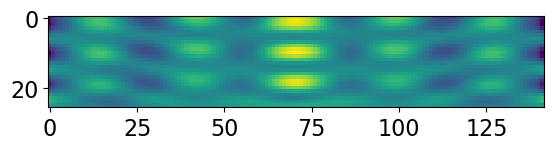

In [197]:
plt.figure()
plt.imshow(np.rot90(grad.reshape(NX, NY)))

<Axes: xlabel='X', ylabel='Y'>

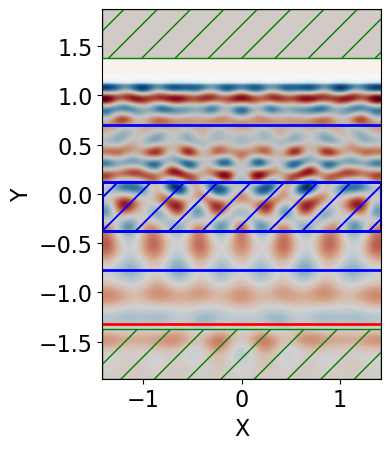

In [193]:
# sim.run(until = 1)
sim.plot2D(fields = mp.Ez)

In [303]:
# ==========================================================
# 회절차수 m에 따른 k_x 및 방출각(공기/기판) 표 출력  [cycles/um]
#  - 모든 "전파 가능한" 차수를 자동으로 전부 출력
#  - 옵션: 에반escent 차수도 지정 범위까지 추가 출력 가능
# ==========================================================
import numpy as _np

def _kx_theta_table_cyc(lambda0, sx, n_list, label_list, include_evanescent=False, evan_extra=0):
    # cycles/um 단위
    k0_cyc = 1.0 / lambda0
    G_cyc  = 1.0 / sx

    print("\n=== Grating params (cycles/um) ===")
    print(f"lambda0 = {lambda0:.6f} um,  k0 = {k0_cyc:.9f} cycles/um")
    print(f"sx(Λ)   = {sx:.6f} um,     G  = {G_cyc:.9f} cycles/um")

    # --- 각 매질별 전파가능 m 범위 계산 (유한 개) ---
    prop_ranges = []
    for n in n_list:
        m_min = int(_np.ceil(- (k0_cyc * n) / G_cyc))
        m_max = int(_np.floor(  (k0_cyc * n) / G_cyc))
        prop_ranges.append((m_min, m_max))

    # --- 전체 m 집합(전파 가능한 모든 차수)을 "합집합"으로 구성 ---
    global_m_min = min(m_min for (m_min, m_max) in prop_ranges)
    global_m_max = max(m_max for (m_min, m_max) in prop_ranges)

    if include_evanescent and evan_extra > 0:
        global_m_min -= int(abs(evan_extra))
        global_m_max += int(abs(evan_extra))

    # --- 표 출력 ---
    for (n, lab) in zip(n_list, label_list):
        k_cut = k0_cyc * n  # 전파 컷오프
        # 이 매질에서의 "전파가능 범위" (참고용)
        m_min_n = int(_np.ceil(-k_cut / G_cyc))
        m_max_n = int(_np.floor( k_cut / G_cyc))
        print(f"\n--- {lab} (n = {n}) ---")
        print(f"[propagating m range] m ∈ [{m_min_n}, {m_max_n}]  (총 {m_max_n - m_min_n + 1}개)")

        # 모든 m(전파 + 선택적 에반escent)을 프린트
        for m in range(global_m_min, global_m_max + 1):
            kx_cyc = m * G_cyc
            if abs(kx_cyc) <= k_cut + 1e-15:
                # 전파
                arg = _np.clip(kx_cyc / k_cut, -1.0, 1.0)
                theta = _np.degrees(_np.arcsin(arg))
                print(f"m={m:+d}: k_x={kx_cyc:+.9f} cycles/um | θ={theta:+.6f} deg  [Prop]")
            else:
                # 에반escent
                if include_evanescent:
                    print(f"m={m:+d}: k_x={kx_cyc:+.9f} cycles/um | Evanescent")

# ----------------------------------------------------------
# (옵션) 목표 각에 가장 가까운 정수 m 제안 [cycles/um]
# ----------------------------------------------------------
def _suggest_m_for_theta_cyc(lambda0, sx, n, theta_deg):
    """
    목표 각 θ에 가장 가까운 정수 차수 m을 제안 (cycles/um 기반).
    """
    k0_cyc = 1.0 / lambda0
    G_cyc  = 1.0 / sx
    kx_star = k0_cyc * n * _np.sin(_np.radians(theta_deg))
    m_real  = kx_star / G_cyc
    m_near  = int(_np.round(m_real))
    print(f"\n[Suggest m] n={n}, target θ={theta_deg} deg  (units: cycles/um)")
    print(f"  kx* = {kx_star:.9f} cycles/um,  m* (real) = {m_real:.6f} -> m_near = {m_near}")

    # 전파 가능성 및 각도 오차 보고
    if abs(m_near * G_cyc) <= k0_cyc * n + 1e-15:
        theta_near = _np.degrees(_np.arcsin(_np.clip((m_near * G_cyc) / (k0_cyc * n), -1.0, 1.0)))
        err_deg = theta_near - theta_deg
        print(f"  with m={m_near}: θ={theta_near:.6f} deg  (error {err_deg:+.6f} deg)")
    else:
        print(f"  with m={m_near}: Evanescent (|m|G > k0 n)")
        
_lambda0 = lambda0     # [um]
_sx      = sx          # [um]
_n_air   = 1.0
_n_sub   = 2.0

# 1) 전파 가능한 모든 차수 전부 출력 (에반escent는 생략)
_kx_theta_table_cyc(
    lambda0=_lambda0,
    sx=_sx,
    n_list=[_n_air, _n_sub],
    label_list=["Air", "Substrate"],
    include_evanescent=False
)

# 2) 전파 차수 전부 + 에반escent를 ±5 차수까지 추가 출력하고 싶다면:
_kx_theta_table_cyc(
    lambda0=_lambda0,
    sx=_sx,
    n_list=[_n_air, _n_sub],
    label_list=["Air", "Substrate"],
    include_evanescent=True,
    evan_extra=5
)

# 3) 목표 각에 가장 가까운 m 제안
_suggest_m_for_theta_cyc(lambda0=_lambda0, sx=_sx, n=1, theta_deg=-45.0)



=== Grating params (cycles/um) ===
lambda0 = 0.500000 um,  k0 = 2.000000000 cycles/um
sx(Λ)   = 2.828000 um,     G  = 0.353606789 cycles/um

--- Air (n = 1.0) ---
[propagating m range] m ∈ [-5, 5]  (총 11개)
m=-5: k_x=-1.768033946 cycles/um | θ=-62.130791 deg  [Prop]
m=-4: k_x=-1.414427157 cycles/um | θ=-45.008654 deg  [Prop]
m=-3: k_x=-1.060820368 cycles/um | θ=-32.033173 deg  [Prop]
m=-2: k_x=-0.707213579 cycles/um | θ=-20.708082 deg  [Prop]
m=-1: k_x=-0.353606789 cycles/um | θ=-10.183622 deg  [Prop]
m=+0: k_x=+0.000000000 cycles/um | θ=+0.000000 deg  [Prop]
m=+1: k_x=+0.353606789 cycles/um | θ=+10.183622 deg  [Prop]
m=+2: k_x=+0.707213579 cycles/um | θ=+20.708082 deg  [Prop]
m=+3: k_x=+1.060820368 cycles/um | θ=+32.033173 deg  [Prop]
m=+4: k_x=+1.414427157 cycles/um | θ=+45.008654 deg  [Prop]
m=+5: k_x=+1.768033946 cycles/um | θ=+62.130791 deg  [Prop]

--- Substrate (n = 2.0) ---
[propagating m range] m ∈ [-11, 11]  (총 23개)
m=-11: k_x=-3.889674682 cycles/um | θ=-76.511970 deg  [Prop]

In [690]:
# =========================================
# 산란장 기반 + RMS 윈도 보정 + 절대/상대 효율 안전 계산
#   - 연속 kx(직접 DFT) Half-Polar (fractional 곡선)
#   - 정수 차수 오버랩 마커
# =========================================
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

# --------- 필수 입력(이미 가지고 있어야 함) ----------
# 동일 위치/크기의 DFT 라인 모니터에서 얻은 주파수 성분:
#   dft_t_total: 구조 포함 시뮬에서의 모니터 핸들
#   dft_t_inc  : 구조 제거(baseline) 시뮬에서의 동일 모니터 핸들
# 아래 변수도 이미 정의되어 있어야 함: sim, sx, lambda0, resolution
# (옵션) 절대 효율을 위한 입사 파워(베이스라인 flux):
INCIDENT_POWER = None  # 예: INCIDENT_POWER = baseline_incident_flux_value

# --------- 기본 파라미터 ----------
Lambda_um = sx
G_cyc     = 1.0 / Lambda_um
k0_cyc    = 1.0 / lambda0
n_medium  = 1.0   # 모니터측 배경 굴절률
kx_inc    = 0.0   # 정상입사 가정
kB_cyc    = 0.0   # Bloch shift가 있으면 설정

# --------- 1) 산란장 DFT 라인 구성 ----------
E_total = np.squeeze(np.array(sim.get_dft_array(dft_t_total, mp.Ez, 0))).ravel()
E_inc   = np.squeeze(np.array(sim.get_dft_array(dft_t_inc,   mp.Ez, 0))).ravel()
Ez_line = E_total - E_inc                       # 반드시 산란장!

N  = len(Ez_line)
dx = Lambda_um / N
x0 = -0.5 * Lambda_um
x  = x0 + dx * np.arange(N)

# --------- 2) 윈도 & RMS 보정 (파워 기준) ----------
use_window = True
if use_window:
    w = np.hanning(N)
    w_rms = np.sqrt(np.mean(w**2))              # 파워 보존을 위한 RMS gain
    Ez_proc = (Ez_line * w) / (w_rms + 1e-30)
else:
    Ez_proc = Ez_line

# --------- 3) 연속 kx 직접 DFT (fractional) ----------
kx_min = -n_medium * k0_cyc
kx_max =  n_medium * k0_cyc
num_kx = 4001
kx_cont = np.linspace(kx_min, kx_max, num_kx)

# S(kx) = (1/L) ∫ E(x) e^{-i2π kx x} dx  ≈ (1/N) Σ E e^{-i2π kx x}
phase_mat = np.exp(-1j * 2*np.pi * np.outer(kx_cont, x))  # (num_kx, N)
S_kx = (phase_mat @ Ez_proc) / N

# 물리 파워 가중 (TM/Ez): ∝ cosθ * |S|^2
power_cont = np.abs(S_kx)**2
beta_cont  = np.clip(kx_cont / (n_medium * k0_cyc + 1e-30), -1.0, 1.0)
cos_cont   = np.sqrt(np.clip(1.0 - beta_cont**2, 0.0, 1.0))
power_cont_w = power_cont * cos_cont

# 상대 분포(전파합=100%)와 절대 스케일(입사 기준)을 둘 다 준비
# - 상대: 연속 분포 적분이 100%가 되도록
sum_pw = np.trapz(power_cont_w, kx_cont) + 1e-30
cont_percent = power_cont_w / sum_pw * 100.0

# - 절대: INCIDENT_POWER가 있으면 P_abs(kx) = const * power_cont_w / INCIDENT_POWER
#   (const는 임피던스/정규화 상수이지만, '연속분포 적분 == 모니터 총 산란 플럭스'에 맞춰
#    스케일을 정하려면 같은 평면의 산란 플럭스를 별도로 측정해 맞추세요.)
use_absolute = (INCIDENT_POWER is not None)

# --------- 4) 정수 차수 오버랩 (per-order) ----------
m_max  = int(np.floor(n_medium * k0_cyc / G_cyc + 1e-12))
m_list = np.arange(-m_max, m_max + 1, dtype=int)

# 산란장으로 계산!
C_m = np.zeros_like(m_list, dtype=np.complex128)
norm_fac = 1.0 / N
for i, m in enumerate(m_list):
    kx_m = kx_inc + m * G_cyc
    C_m[i] = norm_fac * np.sum(Ez_line * np.exp(-1j * 2*np.pi * kx_m * x))

kx_m_arr = kx_inc + m_list * G_cyc
beta_m   = np.clip(kx_m_arr / (n_medium * k0_cyc + 1e-30), -1.0, 1.0)
cos_m    = np.sqrt(np.clip(1.0 - beta_m**2, 0.0, 1.0))
P_m_rel  = cos_m * (np.abs(C_m)**2)

if use_absolute:
    # 절대 효율 [%]  =  (상수 * P_m_rel) / INCIDENT_POWER * 100
    # 상수를 맞추려면 같은 평면의 '총 산란 플럭스'를 측정해
    # sum_m(상수*P_m_rel) == measured_scat_flux 로 세팅하면 됩니다.
    # 여기서는 분포만 보려면 합을 INCIDENT_POWER로 직접 나누지 말고,
    # per-order 대신 '총 산란 플럭스'로 스케일을 정해주세요.
    eta_m_percent = P_m_rel / (np.sum(P_m_rel) + 1e-30) * 100.0  # 안전: 일단 상대
    abs_label = False
else:
    # 상대 효율: per-order 합을 100%로
    eta_m_percent = P_m_rel / (np.sum(P_m_rel) + 1e-30) * 100.0
    abs_label = False

# --------- 5) Half-Polar 플롯 (연속 + 정수 마커) ----------
# 연속
theta_cont = np.full_like(kx_cont, np.nan, dtype=float)
prop_cont  = (np.abs(kx_cont) <= n_medium * k0_cyc + 1e-15)
theta_cont[prop_cont] = np.arcsin(np.clip(kx_cont[prop_cont] / (n_medium * k0_cyc), -1.0, 1.0))
valid = np.isfinite(theta_cont)
th_c  = theta_cont[valid]
rc    = cont_percent[valid]
if th_c.size > 0:
    idx = np.argsort(th_c)
    th_c = th_c[idx]; rc = rc[idx]

# 정수
theta_m = np.full_like(kx_m_arr, np.nan, dtype=float)
prop_m  = (cos_m > 0)
theta_m[prop_m] = np.arcsin(np.clip(kx_m_arr[prop_m] / (n_medium * k0_cyc), -1.0, 1.0))

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='polar')
ax.set_theta_zero_location('N'); ax.set_theta_direction(-1)
ax.set_thetamin(-90); ax.set_thetamax(90)
ax.set_thetagrids(range(-90, 91, 30), labels=[f"{t}°" for t in range(-90, 91, 30)])

if th_c.size > 0: ax.plot(th_c, rc, '-', lw=1.6, label="continuous (fractional)")
ax.plot(theta_m[prop_m], eta_m_percent[prop_m], 'o', ms=7, label="integer (overlap)")

ax.set_rmin(0.0); ax.set_rmax(100.0); ax.set_rlabel_position(90)
ttl = "Half-Polar " + ("Absolute (%)" if abs_label else "Relative (%)")
ax.set_title(f"{ttl} — n={n_medium}, λ0={lambda0} μm", va='bottom')
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
plt.grid(True, which='both', alpha=0.3)
plt.show()


NameError: name 'dft_t_total' is not defined

In [ ]:
# --- FourierFields 모니터 (y=0.7 선) ---
ff_center = mp.Vector3(0, 0.7, 0)
ff_size   = mp.Vector3(sx, 0, 0)
ff_vol    = mp.Volume(center=ff_center, size=ff_size)

ff_Ez = mpa.FourierFields(sim, volume=ff_vol, component=mp.Ez)

# --- k_x vector 추가 보정 ---
margin = 0.4  # [um] 디자인 하단 바로 아래로 살짝 내림

# 디자인 하단 y좌표
design_bottom_y = design_region.center.y - 0.5 * design_region.size.y

# 추가 모니터의 중심과 크기 (x는 주기 전체 길이)
ff_center_below = mp.Vector3(0, design_bottom_y - margin, 0)
ff_size_below   = mp.Vector3(sx, 0, 0)
ff_vol_below    = mp.Volume(center=ff_center_below, size=ff_size_below)

ff_check_Ez = mpa.FourierFields(sim, volume=ff_vol_below, component=mp.Ez)

def J_kx(Ez_line_top, Ez_line_bot):
    # ---- 매질 내의 모니터 () ----
    Ez_top  = npa.ravel(Ez_line_top)
    fft_top = npa.fft.fftshift(npa.fft.fft(Ez_top))
    kx_top  = npa.fft.fftshift(npa.fft.fftfreq(len(fft_top), d=1.0/resolution))
    idx0_top = npa.argmin(npa.abs(kx_top)) + 1

    num_top = npa.abs(fft_top[idx0_top])**2
    den_top = npa.sum(npa.abs(fft_top)**2)
    frac_top = npa.abs(num_top / den_top)       

    # ---- 공기층 모니터 (check) ----
    Ez_bot  = npa.ravel(Ez_line_bot)
    fft_bot = npa.fft.fftshift(npa.fft.fft(Ez_bot))
    kx_bot  = npa.fft.fftshift(npa.fft.fftfreq(len(fft_bot), d=1.0/resolution))
    idx0_bot = npa.argmin(npa.abs(kx_bot)) + 1   

    num_bot = npa.abs(fft_bot[idx0_bot])**2
    den_bot = npa.sum(npa.abs(fft_bot)**2)
    frac_bot = npa.abs(num_bot / den_bot)       

    H = 2.0 * frac_top * frac_bot / (frac_top + frac_bot)
    return H

# OptimizationProblem (예시)
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J_kx],
    objective_arguments=[ff_Ez, ff_check_Ez],
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-3,
    minimum_run_time=50/fcen,
)


In [ ]:
import matplotlib as mpl
mpl.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16
})

Ez_line = np.squeeze(np.array(sim.get_dft_array(check_monitor, mp.Ez, 0))).ravel()  # 기존 Ez_line 유지, 1D 보장
fft_Ez  = np.fft.fftshift(np.fft.fft(Ez_line))  # 기존 변수명 유지
kx = np.fft.fftshift(np.fft.fftfreq(len(fft_Ez), d = dx))

plt.figure(figsize=(8,8))
plt.plot(kx, np.abs(fft_Ez),'ro-')  

plt.xlabel(r"$k_x$ [cycles / $\mu$m]")   # kx 축 (주기수 단위)
plt.ylabel(r"$|FFT(E_z)|$")             # 스펙트럼 크기
plt.title("Ez FFT magnitude (index axis)")
plt.grid(True, which="both", alpha=0.3)
# plt.xlim(-5,5)
plt.tight_layout()